In [16]:
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    set_seed, BertConfig, BertTokenizer, BertForSequenceClassification,
)
import torch
import numpy as np

In [4]:
device = torch.device('cuda')
config = AutoConfig.from_pretrained('/home/lichunhao/novel_need/prompt1_result/', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('/home/lichunhao/novel_need/prompt1_result/', use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    '/home/lichunhao/novel_need/prompt1_result/',
    from_tf=False,
    config=config,
)


model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [5]:
batch_sentences = ["Hello I'm a single sentence",
                    "And another sentence",
                    "And the very very last one"]

tokenizer(batch_sentences)

{'input_ids': [[101, 7592, 1045, 1005, 1049, 1037, 2309, 6251, 102], [101, 1998, 2178, 6251, 102], [101, 1998, 1996, 2200, 2200, 2197, 2028, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

In [7]:
# from transformers import pipeline

# feature_extraction = pipeline('feature-extraction', model="/home/lichunhao/novel_need/prompt1_result/", tokenizer="/home/lichunhao/novel_need/prompt1_result/")
# features = feature_extraction(["Hello I'm a single sentence",
#                                "And another sentence",
#                                "And the very very last one"])

Some weights of the model checkpoint at /home/lichunhao/novel_need/prompt1_result/ were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
import torch
import pandas as pd

In [11]:
df_train = pd.read_csv('/home/lichunhao/novel_need/data/novel_train_prompt1.csv')
df_valid = pd.read_csv('/home/lichunhao/novel_need/data/novel_valid_prompt1.csv')

In [12]:
pos_sentences = []
neg_sentences = []
pos_sentences2 = []
neg_sentences2 = []
for _,row in df_valid.iterrows():
    if row['label']==0:
        neg_sentences.append(row['sentence1'])
    else:
        pos_sentences.append(row['sentence1'])
        
        
for _,row in df_train.iterrows():
    if row['label']==0:
        neg_sentences2.append(row['sentence1'])
    else:
        pos_sentences2.append(row['sentence1'])

In [13]:
len(pos_sentences), len(neg_sentences), len(pos_sentences2), len(neg_sentences2)

(16, 3358, 64, 13429)

In [14]:
from tqdm import tqdm
pos_embeddings=[]
neg_embeddings=[]

for sent in tqdm(pos_sentences+pos_sentences2):
    input_ids = torch.tensor(tokenizer.encode(sent, padding='max_length', max_length=128, truncation=True)).unsqueeze(0)
    outputs = model(input_ids.to(device))
    pos_embeddings.append(outputs[0].detach().cpu().numpy())
    
for sent in tqdm(neg_sentences+neg_sentences2):
    input_ids = torch.tensor(tokenizer.encode(sent, padding='max_length', max_length=128, truncation=True)).unsqueeze(0)
    outputs = model(input_ids.to(device))
    neg_embeddings.append(outputs[0].detach().cpu().numpy())
    

100%|██████████| 16787/16787 [02:31<00:00, 110.99it/s]


In [17]:
pos_embeddings = np.array(pos_embeddings).reshape(len(pos_embeddings),2)
neg_embeddings = np.array(neg_embeddings).reshape(len(neg_embeddings),2)

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# tsne = TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=3)

# pos_embedded = tsne.fit_transform(pos_embeddings)
# neg_embedded = tsne.fit_transform(neg_embeddings)

In [20]:
# fig = plt.figure()
# ax = plt.subplot(111)
# plt.scatter(pos_embedded[:,0], pos_embedded[:, 1], c='blue')
# plt.scatter(neg_embedded[:,0], neg_embedded[:, 1], c='red')
# # plt.scatter(pos_embeddings[:,0], pos_embeddings[:, 1], c='blue')
# # plt.scatter(neg_embeddings[:,0], neg_embeddings[:, 1], c='red')

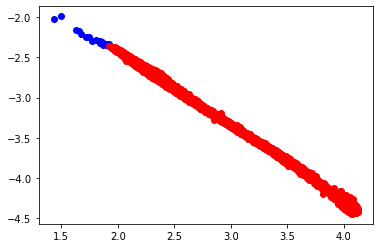

In [21]:
fig = plt.figure()
ax = plt.subplot(111)
# plt.scatter(pos_embedded[:,0], pos_embedded[:, 1], c='blue')
# plt.scatter(neg_embedded[:,0], neg_embedded[:, 1], c='red')
plt.scatter(pos_embeddings[:,0], pos_embeddings[:, 1], c='blue')
plt.scatter(neg_embeddings[:,0], neg_embeddings[:, 1], c='red')

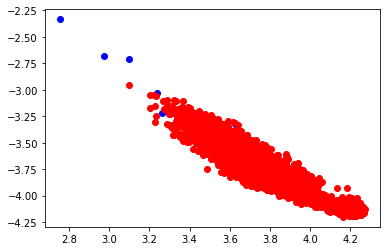

In [74]:
fig = plt.figure()
ax = plt.subplot(111)
# plt.scatter(pos_embedded[:,0], pos_embedded[:, 1], c='blue')
# plt.scatter(neg_embedded[:,0], neg_embedded[:, 1], c='red')
plt.scatter(pos_embeddings[:,0], pos_embeddings[:, 1], c='blue')
plt.scatter(neg_embeddings[:,0], neg_embeddings[:, 1], c='red')

In [76]:
from transformers import pipeline

feature_extraction = pipeline('feature-extraction', model="v3_result", tokenizer="v3_result")
pos_features = feature_extraction(pos_sentences)

# neg_features = feature_extraction(neg_sentences)

Some weights of the model checkpoint at v3_result were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [86]:
# [emb[0] for emb in pos_features]

In [91]:
np.array([np.array(x) for x in pos_features[2][0]]).shape

(12, 768)